In [395]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import math

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda
from keras.models     import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.objectives import mse, binary_crossentropy

import keras.backend as K
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [264]:
def true_prob_vector (x) :
    x_mod = (x+10) / 3
    #spectrum = np.max([[0 for i in range(len(x_mod))], 1./x_mod], axis=0)
    spectrum = 1./(x_mod) + stats.norm.pdf(x, 60, 5)
    return spectrum / np.sum(spectrum)

In [265]:
def generate_dataset (n_points, x_min=0, x_max=100, granularity=0.1) :
    x   = np.linspace(x_min, x_max, 1 + math.ceil((x_max-x_min)/granularity))
    px  = true_prob_vector(x)
    prev, cdf = 0, []
    for pxi in px :
        new_cdf = prev + pxi
        cdf.append(new_cdf)
        prev = new_cdf
    return np.interp(np.random.uniform(0, 1, n_points), cdf, x)

In [354]:
def whiten_data (dataset, params=None) :
    if params == None :
        params = np.median(dataset), np.std(dataset)
    return (dataset - params[0]) / params[1] , params

def unwhiten_data (dataset, params) :
    return params[0] + (dataset * params[1])

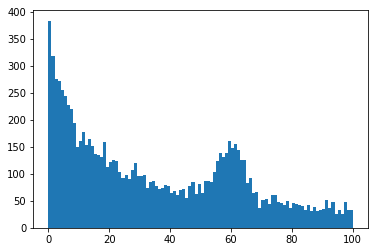

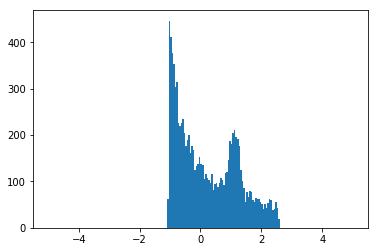

In [355]:
dataset = generate_dataset(10000)
plt.hist(dataset, bins=np.linspace(0, 100, 101))
plt.show()

white_dataset, whitening_params = whiten_data(dataset)
plt.hist(white_dataset, bins=np.linspace(-5, 5, 201))
plt.show()

In [506]:
def create_autoencoder () :
    
    #  define function which adds random noise according to (z_mean, s_log_sigma) and creates z
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=K.shape(z_mean))
        return z_mean + K.exp(z_log_sigma) * epsilon

    #  define encoder loss function
    def encoder_loss(y_true, y_pred):
        kl_loss   = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return kl_loss

    #  define VAE loss function
    def vae_loss(y_true, y_pred):
        reco_loss = mse(y_true, y_pred)   # mse(y_true, y_pred)
        kl_loss   = encoder_loss(y_true, y_pred)
        return reco_loss + kl_loss
    
    #  create encoder
    input_layer   = Input(shape=(1,))
    encoder       = Dense(15, activation='linear')(input_layer)
    encoder       = LeakyReLU(0.2)(encoder)
    encoder       = Dense(15, activation='linear')(encoder)
    encoder       = LeakyReLU(0.2)(encoder)
    z_mean        = Dense(1 , activation='linear')(encoder)
    z_log_sigma   = Dense(1 , activation='linear')(encoder)
    encoder       = Lambda(sampling)([z_mean, z_log_sigma])   #  include sampling functionaliy as Lambda layer
    encoder_model = Model(input_layer, encoder)
    encoder_model.compile(optimizer='rmsprop', loss=encoder_loss)

    #  create autoencoder
    decoder_layers = []
    decoder_layers.append(Dense(15, activation='linear'))
    decoder_layers.append(LeakyReLU(0.2))
    decoder_layers.append(Dense(15, activation='linear'))
    decoder_layers.append(LeakyReLU(0.2))
    decoder_output = Dense(1 , activation='linear')
    
    decoder_layer_vae = decoder_layers[0](encoder)
    for layer in decoder_layers[1:] : decoder_layer_vae = layer(decoder_layer_vae)
    decoder_output_vae = decoder_output(decoder_layer_vae)
    vae_model = Model(input_layer, decoder_output_vae)
    vae_model.compile(optimizer='rmsprop', loss=vae_loss)

    #  create generator
    generator_input = Input(shape=(1,))
    decoder_layer_gen = decoder_layers[0](generator_input)
    for layer in decoder_layers[1:] : decoder_layer_gen = layer(decoder_layer_gen)
    decoder_output_gen = decoder_output(decoder_layer_gen)
    generator_model = Model(generator_input, decoder_output_gen)
    
    #  return all models
    return encoder_model, generator_model, vae_model



In [513]:
def create_boxy_autoencoder () :
    
    #  define function which adds random noise according to (z_mean, s_log_sigma) and creates z
    def sampling(args):
        z_lo, z_hi = args
        return K.random_uniform(shape=K.shape(z_lo), minval=z_lo, maxval=z_hi)

    #  define encoder loss function
    def encoder_loss(x, x_decoded_mean):
        loss = K.sum(z_lo*z_lo + (z_hi-1)*(z_hi-1))
        return loss

    #  define VAE loss function
    def vae_loss(x, x_decoded_mean):
        xent_loss = mse(x, x_decoded_mean)
        loss      = encoder_loss(x, x_decoded_mean)
        return xent_loss + loss
    
    #  create encoder
    input_layer   = Input(shape=(1,))
    encoder       = Dense(15, activation='linear')(input_layer)
    encoder       = LeakyReLU(0.2)(encoder)
    #encoder       = Dense(15, activation='linear')(encoder)
    #encoder       = LeakyReLU(0.2)(encoder)
    z_lo          = Dense(1 , activation='linear')(encoder)
    z_hi          = Dense(1 , activation='linear')(encoder)
    encoder       = Lambda(sampling)([z_lo, z_hi])   #  include sampling functionaliy as Lambda layer
    encoder_model = Model(input_layer, encoder)
    encoder_model.compile(optimizer='rmsprop', loss=encoder_loss)

    #  create autoencoder
    decoder_layers = []
    decoder_layers.append(Dense(15, activation='linear'))
    decoder_layers.append(LeakyReLU(0.2))
    #decoder_layers.append(Dense(15, activation='linear'))
    #decoder_layers.append(LeakyReLU(0.2))
    decoder_output = Dense(1 , activation='linear')
    
    decoder_layer_vae = decoder_layers[0](encoder)
    for layer in decoder_layers[1:] : decoder_layer_vae = layer(decoder_layer_vae)
    decoder_output_vae = decoder_output(decoder_layer_vae)
    vae_model = Model(input_layer, decoder_output_vae)
    vae_model.compile(optimizer='rmsprop', loss=vae_loss)

    #  create generator
    generator_input = Input(shape=(1,))
    decoder_layer_gen = decoder_layers[0](generator_input)
    for layer in decoder_layers[1:] : decoder_layer_gen = layer(decoder_layer_gen)
    decoder_output_gen = decoder_output(decoder_layer_gen)
    generator_model = Model(generator_input, decoder_output_gen)
    
    #  return all models
    return encoder_model, generator_model, vae_model


In [514]:
encoder_model, generator_model, vae_model = create_autoencoder()

In [515]:
vae_model.fit(white_dataset, 
              white_dataset,
              batch_size       = 200,
              validation_split = 0.4,
              callbacks        = [EarlyStopping(patience=50, restore_best_weights=True)],
              epochs           = 100000,
              shuffle          = True,
              #batch_size=1000
           )

Train on 6000 samples, validate on 4000 samples
Epoch 1/100000
6000/6000 [==============================] - 2s 334us/step - loss: 1.0266 - val_loss: 0.9752
Epoch 2/100000
6000/6000 [==============================] - 0s 17us/step - loss: 0.9252 - val_loss: 0.9288
Epoch 3/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.8813 - val_loss: 0.8023
Epoch 4/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.7131 - val_loss: 0.6711
Epoch 5/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6503 - val_loss: 0.6341
Epoch 6/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6322 - val_loss: 0.6292
Epoch 7/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6160 - val_loss: 0.6164
Epoch 8/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6141 - val_loss: 0.6098
Epoch 9/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6068 - val_l

6000/6000 [==============================] - 0s 14us/step - loss: 0.5959 - val_loss: 0.5978
Epoch 77/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6000 - val_loss: 0.6067
Epoch 78/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.5942 - val_loss: 0.5985
Epoch 79/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.5938 - val_loss: 0.6050
Epoch 80/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.5971 - val_loss: 0.6076
Epoch 81/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.5975 - val_loss: 0.6056
Epoch 82/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.5967 - val_loss: 0.6057
Epoch 83/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.6011 - val_loss: 0.6029
Epoch 84/100000
6000/6000 [==============================] - 0s 14us/step - loss: 0.5972 - val_loss: 0.6003
Epoch 85/100000
6000/6000 [=================

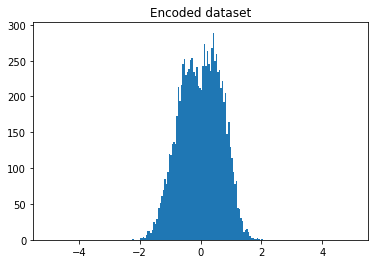

-0.0043720724
0.6701439


In [519]:
sorted_white_dataset = sorted(white_dataset)

encoded_dataset = encoder_model.predict(white_dataset)
plt.hist(encoded_dataset, bins=np.linspace(-5, 5, 201))
plt.title("Encoded dataset")
plt.show()

'''encoded_dataset2 = encoder_model.predict(sorted_white_dataset[:int(0.2*len(sorted_white_dataset))])
plt.hist(encoded_dataset2, bins=np.linspace(-5, 5, 201))
plt.show()

encoded_dataset2 = encoder_model.predict(sorted_white_dataset[int(0.8*len(sorted_white_dataset)):])
plt.hist(encoded_dataset2, bins=np.linspace(-5, 5, 201))
plt.show()'''

print(np.mean(encoded_dataset))
print(np.std(encoded_dataset))

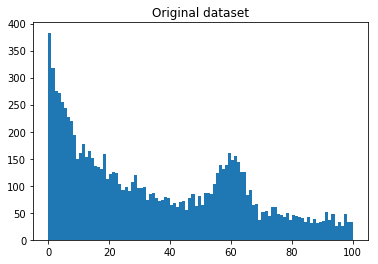

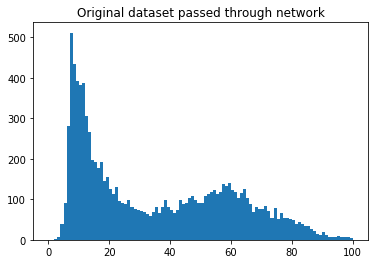

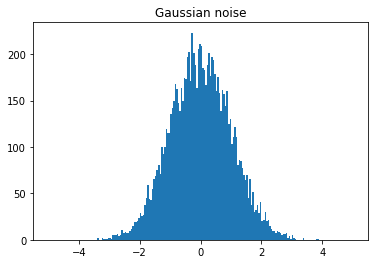

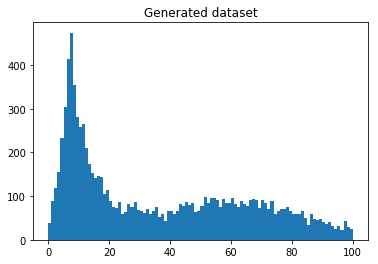

In [520]:
plt.hist(dataset, bins=np.linspace(0, 100, 101))
plt.title("Original dataset")
plt.show()

decoded_dataset = unwhiten_data(generator_model.predict(encoded_dataset), whitening_params)
plt.hist(decoded_dataset, bins=np.linspace(0, 100, 101))
plt.title("Original dataset passed through network")
plt.show()

latent_noise = np.random.normal(size=(10000,))
plt.hist(latent_noise, bins=np.linspace(-5, 5, 201))
plt.title("Gaussian noise")
plt.show()

generated_dataset = unwhiten_data(generator_model.predict(latent_noise), whitening_params)
plt.hist(generated_dataset, bins=np.linspace(0, 100, 101))
plt.title("Generated dataset")
plt.show()

It seems that any interesting structure in the distribution, necessarily leads to non-Gaussian behaviour in the latent space, since mapping onto a Gaussian for every datapoint means throwing away information, and the encoder acts against this when there is information present. When we sample over the latent space (Gaussianly) then we necessarily lose this structure.

There are also edge-effect problems (the VAE wants to smoothly transition to/from 0 probability)

A "true" VAE would parameterise the probability density over x for each z, p(x|z), but we would then need to sample over z and integrate over x to build p(x|z).

All ways of turning the decoder into a stochastic data generator, from a reproucible noise distribution, seem to just be making a GAN.

Turning the output into a model of p(x) seem like density estimation.

What if we use a discriminative classifier? I.e. train something which can learn p(c|x), then use the generative model to sample over x for a given c, and see how tight the observed bounds on c are (with the presence of background)? Or even better, use density estimation to parameterise p(x|c) for SM and BSM, and backprop the value function all the way back to c